# NYC Subway Dataset Analysis

## Assignment

Purpose of this assignment is to analyze subway ridership dataset and see if external elements like rain significantly influence the number of passengers.  
Also, we need to predict number of passengers based on parameters we previously analyzed.

## Disclaimers

Part of the this assigment are also questions in Problem Sets 2, 3, and 4 in the Introduction to Data Science course.  
I have resolved all of those.  
On couple of them, server would return some unrelated errors and my submission would fail even though I did get required plots.  
This only happens when dealing with ggplot.

## Loading Data and Defining Functions

## Section 0. References

1. Udacity "Intro to Data Science" videos
2. pandas, numpy, sklearn, ggplot documentation
3. http://matplotlib.org/users/pyplot_tutorial.html
4. http://matplotlib.org/examples/api/barchart_demo.html
5. https://www.youtube.com/watch?v=pHrwqLhAaMw

## Section 1. Statistical Test

### Question 1.1
Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?

#### Answer
**H0: µ_entries_rain = µ_entries_no_rain**  
Mean of entries on the days it rains is the same as the mean of entries on the days when it doesn't rain  
**H1: µ_entries_rain ≠ µ_entries_no_rain**  
Mean of entries on the days it rains is different than the mean of entries on the days when it doesn't rain  
  
I am using one-tail p value.

p_critical = 0.05  
  
I used Mann-Whitney u-test since the data was not normally distributed.

#### Calculation
First we need to agregate *entries* and *rain* by days.

In [152]:
import numpy as np
import pandas
import pandasql
from sklearn.linear_model import SGDRegressor
import scipy
from ggplot import *
%matplotlib inline 

pandas.set_option('display.max_columns', None)
data = pandas.read_csv('data/weather.csv')
print data.iloc[0]

##ggplot(data, aes(x="ENTRIESn")) + geom_histogram() #+ facet_wrap("hour")

UNIT                              R003
DATEn                         05-01-11
TIMEn                         00:00:00
ENTRIESn                       4388333
EXITSn                         2911002
ENTRIESn_hourly                      0
EXITSn_hourly                        0
datetime           2011-05-01 00:00:00
hour                                 0
day_week                             6
weekday                              0
station                  CYPRESS HILLS
latitude                      40.68995
longitude                    -73.87256
conds                            Clear
fog                                  0
precipi                              0
pressurei                        30.22
rain                                 0
tempi                             55.9
wspdi                              3.5
meanprecipi                          0
meanpressurei                   30.258
meantempi                        55.98
meanwspdi                         7.86
weather_lat              

In [187]:
q = """
select UNIT, DATEn, max(rain) as rain, weekday, sum(ENTRIESn_hourly) as entries
from data
group by UNIT, DATEn
"""

daily_data = pandasql.sqldf(q, locals())

#print len(daily_data['UNIT'].unique())
#print daily_data

Now we can compare entries on the days that rains vs. the ones that don't.  
Also, we should compare only weekdays with themselves since ridership may vary for weekends.

In [174]:
rains_weekday_data = daily_data['entries'][(daily_data.rain == 1) & (daily_data.weekday == 1)]
no_rain_weekday_data = daily_data['entries'][(daily_data.rain == 0) & (daily_data.weekday == 1)]
rains_weekend_data = daily_data['entries'][(daily_data.rain == 1) & (daily_data.weekday == 0)]
no_rain_weekend_data = daily_data['entries'][(daily_data.rain == 0) & (daily_data.weekday == 0)]

To detect which test we should use we first need to confirm or deny some assumptions we have about data.
First we use Shapiro-Wilk test to see weather our data is normally distributed.

In [175]:
w,p = scipy.stats.shapiro(daily_data['entries'])
print "p = " + str(p)

p = 0.0


/home/veich/installations/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1082: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


We cannot use shapito test due to too large sample size.
But, since we have large enough data sample we can see from the histogram below that our data is not normally distributed.

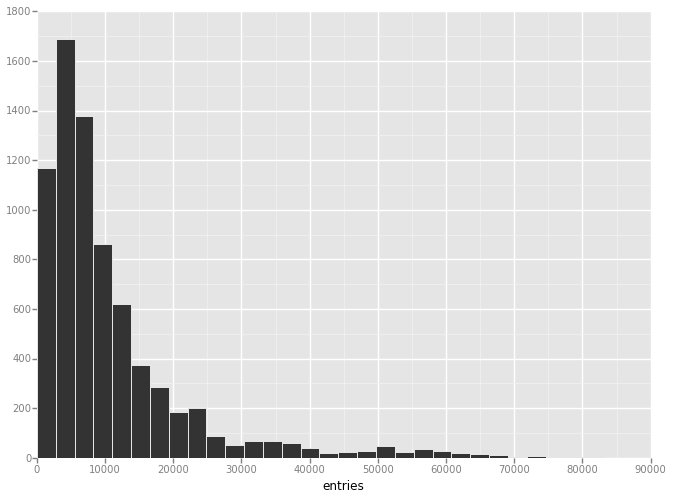

<ggplot: (8730947844153)>

In [176]:
ggplot(daily_data, aes(x="entries")) + geom_histogram()

Because our data is not normally distributed Mann-Whitney u-test seems appropriate to compare data samples.  
This test doesn't assume any particular probability distribution.

### Question 1.2
Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

#### Answer
Mann-Whitney u-test doesn't assume any particular sample distribution which makes it suitable for this data set which is not normally distributed.

### Question 1.3
What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

In [188]:
#rains_weekday_data
#no_rain_weekday_data
#rains_weekend_data
#no_rain_weekend_data

In [197]:
u,p = scipy.stats.mannwhitneyu(rains_weekday_data, no_rain_weekday_data)
print 'p = ' + str(p)
print "entries_mean_weekday_rains_ridership = " + str(np.mean(rains_weekday_data))
print "entries_mean_weekday_no_rain_ridership = " + str(np.mean(no_rain_weekday_data))

p = 0.0496887782637
entries_mean_weekday_rains_ridership = 12970.4450995
entries_mean_weekday_no_rain_ridership = 12328.3840246


Calculated p value is less than our p_critical value (0.05) which means rain has significant impact on ridership on weekdays.

In [198]:
u,p = scipy.stats.mannwhitneyu(rains_weekend_data, no_rain_weekend_data)
print 'p = ' + str(p)
print "entries_mean_weekend_rains_ridership = " + str(np.mean(rains_weekend_data))
print "entries_mean_weekend_no_rain_ridership = " + str(np.mean(no_rain_weekend_data))

p = 0.0829950888061
entries_mean_weekend_rains_ridership = 6193.14814815
entries_mean_weekend_no_rain_ridership = 6939.72384035


p value in this test suggests that rain has no significant impact on subway ridership during the weekend.

In [200]:
u,p = scipy.stats.mannwhitneyu(rains_weekday_data, rains_weekend_data)
print 'p = ' + str(p)
print "entries_mean_weekday_rains_ridership = " + str(np.mean(rains_weekday_data))
print "entries_mean_weekend_rains_ridership = " + str(np.mean(rains_weekend_data))
u,p = scipy.stats.mannwhitneyu(no_rain_weekend_data, no_rain_weekday_data)
print 'p = ' + str(p)
print "entries_mean_weekday_no_rain_ridership = " + str(np.mean(no_rain_weekday_data))
print "entries_mean_weekend_no_rain_ridership = " + str(np.mean(no_rain_weekend_data))

p = 7.68162246312e-32
entries_mean_weekday_rains_ridership = 12970.4450995
entries_mean_weekend_rains_ridership = 6193.14814815
p = 7.60085459706e-103
entries_mean_weekday_no_rain_ridership = 12328.3840246
entries_mean_weekend_no_rain_ridership = 6939.72384035


Calculated p values suggest weekday vs. weekend has significant impact on the subway ridership (accounted for the possible rain impact on the results).

### Question 1.4
What is the significance and interpretation of these results?

#### Answer
Statistical significance of these results is 0.05

## Section 2. Linear Regression

### Question 2.1
What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:
- OLS using Statsmodels or Scikit Learn
- Gradient descent using Scikit Learn
- Or something different?

#### Answer
I used gradient descent from scikit learn.

### Question 2.2
What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?

#### Answer
In my model I used the following variables:
- ENTRIESn_hourly
- rain
- weekend

I didn't use dummy variables.

#### Calculation

In [6]:
def linear_regression(features, values):
    model = SGDRegressor()
    model.fit(features, values)

    intercept = model.intercept_
    params = model.coef_
    
    return intercept, params

In [7]:
def normalize_features(features):
    ''' 
    Returns the means and standard deviations of the given features, along with a normalized feature
    matrix.
    ''' 
    means = np.mean(features, axis=0)
    std_devs = np.std(features, axis=0)
    normalized_features = (features - means) / std_devs
    
    return means, std_devs, normalized_features

In [8]:
def recover_params(means, std_devs, norm_intercept, norm_params):
    ''' 
    Recovers the weights for a linear model given parameters that were fitted using
    normalized features. Takes the means and standard deviations of the original
    features, along with the intercept and parameters computed using the normalized
    features, and returns the intercept and parameters that correspond to the original
    features.
    ''' 
    intercept = norm_intercept - np.sum(means * norm_params / std_devs)
    params = norm_params / std_devs
    
    return intercept, params

In [10]:
def check_normal_distribution(data):
    w,p = scipy.stats.shapiro(data)
    print stats
    if p <= 0.025:
        return Flase
    else:
        return True
        

In [11]:
def filter_data_by_hour(data):
    entries = []
    hours = []

    midnight_value = 0
    for i in range(24):
        entry_sum = np.sum(data["ENTRIESn_hourly"][data.hour == i])
        if entry_sum > 0:

            if i == 0:
                entries.append(entry_sum)
                hours.append(24)
            else:
                entries.insert(i/4-1,entry_sum)
                hours.insert(i/4-1, i)
        i = i + 1;

    filtered_dict = {"hour":hours, "entries":entries}
    filtered_data = pandas.DataFrame(filtered_dict)
    
    return filtered_data

In [12]:
print data["conds"].unique()

['Clear' 'Partly Cloudy' 'Mostly Cloudy' 'Overcast' 'Light Rain'
 'Scattered Clouds' 'Rain' 'Light Drizzle' 'Haze' 'Heavy Rain' 'Fog' 'Mist']


### Question 2.3
Why did you select these features in your model? We are looking for specific reasons that lead you to believe that
the selected features will contribute to the predictive power of your model.
- Your reasons might be based on intuition. For example, response for fog might be: “I decided to use fog because I thought that when it is very foggy outside people might decide to use the subway more often.”
- Your reasons might also be based on data exploration and experimentation, for example: “I used feature X because as soon as I included it in my model, it drastically improved my R2 value.”

Feature selection was based both on data analysis and experimentation.  
  
Variables based on analysis:
- sdad
- dasda
- asd
  
Features based on experimentation and incresasing R^2 value:
- sada
- asdasd
- adsd


### Question 2.4
What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?

### Question 2.5
What is your model’s R2 (coefficients of determination) value?

### Question 2.6
What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?

## Section 3. Visualization

Please include two visualizations that show the relationships between two or more variables in the NYC subway data.
Remember to add appropriate titles and axes labels to your plots. Also, please add a short description below each figure commenting on the key insights depicted in the figure.

### Question 3.1
One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.
- You can combine the two histograms in a single plot or you can use two separate plots.
- If you decide to use to two separate plots for the two histograms, please ensure that the x-axis limits for both of the plots are identical. It is much easier to compare the two in that case.
- For the histograms, you should have intervals representing the volume of ridership (value of ENTRIESn_hourly) on the x-axis and the frequency of occurrence on the y-axis. For example, each interval (along the x-axis), the height of the bar for this interval will represent the number of records (rows in our data) that have ENTRIESn_hourly that falls in this interval.
- Remember to increase the number of bins in the histogram (by having larger number of bars). The default bin width is not sufficient to capture the variability in the two samples.

### Question 3.2
One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. Some suggestions are:
- Ridership by time-of-day
- Ridership by day-of-week

## Section 4. Conclusion

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

### Question 4.1
From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?

#### Answer
More people ride the NYC subway when it rains during weekday.

### Question 4.2
What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.

## Section 5. Reflection

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

### Question 5.1
Please discuss potential shortcomings of the methods of your analysis, including:
- Dataset,
- Analysis, such as the linear regression model or statistical test.

### Question 5.2
(Optional) Do you have any other insight about the dataset that you would like to share with us?